This program is a first pass at processing the 2D phrases. It successfully processes the data for order 1 in the PST, but it requires more processing in order to accurately assess orders 2 and 3 (3 is the current limit without using sparse matrices). The only way we found to assess them accurately is to use for loops, track what is in the current PST, see if that is in the other PST and conduct the assessment. Such a loop would be necessary for each pairing of PSTs.

In [22]:
#RUSSELS CODE: TRANSITION MATRIX CELL
from typing import List, Dict
import numpy as np

def convert_sequence_to_indexes(alphabet, sequence):
    """Convert a sequence of characters to their corresponding indexes in the alphabet."""
    return [alphabet.index(char) for char in sequence]

def build_alphabet_from_dataset(dataset : List[List[str]]) -> List[str]:
    """Iterate through the dataset and build an alphabet of unique items."""
    alphabet = set()
    ordered_alphabet = []
    for row in dataset:
        for item in row:
            if item not in alphabet:
                ordered_alphabet.append(item)
                alphabet.add(item)

    """
    # todo - remove this int conversion if we go to a string based alphabet

    def sort_numeric_if_possible(x):
        try:
            return float(x)
        except ValueError:
            return x

    sorted_alphabet = sorted(list(alphabet), key=sort_numeric_if_possible)
    alphabet_map = {
        item: idx
        for idx, item in enumerate(sorted_alphabet)
    }
    """

    return ordered_alphabet


def build_transition_matrix(
    dataset : List[List[str]],
    order : int,
    alphabet : List[str] = None
):
    """Build a set of transition matrices for a given dataset and order.

    Inputs:
        dataset (List[List[str]]) - a list of sequences of items
        order (int) - the order of the PST to build
        alphabet (List[str]) - an optional list of items. The position in the list is the index in the alphabet
            if not provided, the alphabet will be built from the dataset

    Outputs:
        N [alphabet size, 1] - vector of total entries for each order
        p_starting_symbol (Pi) [alphabet size, 1] - probability distribution over the possible starting states (or symbols) in a sequence. It represents the likelihood of each symbol being the first one observed in a sequence.
    """

    if alphabet is None:
        alphabet = build_alphabet_from_dataset(dataset)
        print('alphabet is None  in transition matrix')

    alphabet_length = len(alphabet)
    print('transition matrix alphabet length',alphabet_length)

    occurrence_mats = [
        np.zeros((alphabet_length,) * (i+1), dtype=np.uint16)
        for i in range(order + 1)
    ]

    p_starting_symbol = np.zeros(alphabet_length, dtype=np.uint16)
    n = np.zeros(order + 1, dtype=np.uint32)

    for cur_sequence in dataset:
        for cur_item_index in range(len(cur_sequence)):

            cur_item = cur_sequence[cur_item_index]
            cur_item_alphabet_index = alphabet.index(cur_item)

            # If this is the first item in the sequence, increment the starting symbol count
            if cur_item_index == 0:
                # Increment the occurrence count of the current syllable
                p_starting_symbol[cur_item_alphabet_index] += 1

            # Iterate through each order of the PST and increment the co-occurrence count
            # of the current syllable with the next order syllables
            # co_occuring_indexes ends up being a list of indexes of the next order syllables
            # that can be used to dereference the current element of the co-occurrence matrix
            co_occuring_indexes = []
            for cur_order in range(0, order + 1):
                # If the sequence is shorter than the current order, skip
                if len(cur_sequence) <= cur_item_index + cur_order:
                    continue

                # increment the total count of sequences of this order
                n[cur_order] += 1

                next_order_item = cur_sequence[cur_item_index + cur_order]
                next_order_syllables_alphabet_index = alphabet.index(next_order_item)

                co_occuring_indexes.append(next_order_syllables_alphabet_index)
                occurrence_mats[cur_order][tuple(co_occuring_indexes)] += 1

    return {
        "occurrence_mats": occurrence_mats,
        "p_starting_symbol": p_starting_symbol,
        "alphabet": alphabet,
        "N": n
    }

In [23]:
##RUSSELS CODE: PST LEARN CELL
#import numpy as np
from collections import deque

def pst_learn(
    f_mat,
    alphabet,
    N,
    L=7,
    p_min=0.0073,
    g_min=0.185,
    r=1.6,
    alpha=17.5,
    p_smoothing=0
):
    """
    PST Learn function based on Ron, Singer, and Tishby's 1996 algorithm "The Power of Amnesia".

    Args:
        f_mat (list): List of frequency tables.
        alphabet (str): String of symbols.
        N (list): Total entries per order.

        L (int): Maximum order (default: 7).
        p_min (float): Minimum occurrence probability (default: 0.0073).
        g_min (float): Minimum transition probability (default: 0.185).
        r (float): Minimum divergence (default: 1.8).
        alpha (float): Smoothing parameter (default: 0).
        p_smoothing (float): Smoothing for probability (default: 0).

    Returns:
        list: A tree array representing the probabilistic suffix tree.
    """

    # Initialize sbar: symbols whose probability >= p_min
    sequence_queue_sbar = [
        [value] for alphabet_index, value in enumerate(alphabet)
        if np.single(f_mat[0][alphabet_index] / N[0]) >= p_min
    ]

    # Initialize tree with empty node
    tbar = [
        {
            'string': [],
            'parent': [],
            'label': [],
            'internal': [],
            'g_sigma_s': [],
            'p': [],
            'f': []
        }
        for _ in range(L + 1)
    ]

    tbar[0].update({
        'string': [[]],
        'parent': [(0, 0)],
        'label': ['epsilon'],
        'internal': [0],
    })

    # Learning process
    while sequence_queue_sbar:
        # this is referred to as S_CHAR in the original code
        cur_sequence = sequence_queue_sbar.pop(0)

        # Convert the sequence to a list of alphabet indexes
        # this is referred to as S_INDEX in the original code
        cur_sequence_indexes = [alphabet.index(item) for item in cur_sequence]

        if len(cur_sequence_indexes) == 0:
            #print(alphabet.index(item))
            continue

        cur_depth = len(cur_sequence_indexes)

        f_vec = retrieve_f_sigma(f_mat, cur_sequence_indexes)

        if len(cur_sequence_indexes) > 1:
            f_suf = retrieve_f_sigma(f_mat, cur_sequence_indexes[1:])
        else:
            f_suf = retrieve_f_sigma(f_mat, [])

        p_sigma_s = f_vec / (np.sum(f_vec) + np.finfo(float).eps)
        p_sigma_suf = f_suf / (np.sum(f_suf) + np.finfo(float).eps)

        ratio = (p_sigma_s + np.finfo(float).eps) / (p_sigma_suf + np.finfo(float).eps)
        psize = p_sigma_s >= (1 + alpha) * g_min

        ratio_test = (ratio >= r) | (ratio <= 1 / r)
        total = np.sum(ratio_test & psize)

        if total > 0:
            if cur_depth < len(tbar):
                tbar[cur_depth]['string'].append(cur_sequence_indexes)
                node, depth = find_parent(cur_sequence_indexes, tbar)
                tbar[cur_depth]['parent'].append((node, depth))
                tbar[cur_depth]['label'].append(cur_sequence)
                tbar[cur_depth]['internal'].append(0)

        if len(cur_sequence_indexes) < L:
            f_vec_prime = retrieve_f_prime(f_mat, cur_sequence_indexes)
            p_sigmaprime_s = f_vec_prime / (N[cur_depth] + np.finfo(float).eps)
            add_nodes = np.where(p_sigmaprime_s >= p_min)[0]

            for j in add_nodes:
                # Prepend the new symbol to the current sequence
                new_sequence = [alphabet[j]] + cur_sequence
                sequence_queue_sbar.append(new_sequence)

    # Post-process the tree
    tbar = fix_path(tbar)
    tbar = find_gsigma(tbar, f_mat, g_min, N, p_smoothing)

    return tbar


def find_parent(sequence, tbar):
    if len(sequence) == 1:
        return 0, 0

    suffix = sequence[1:]
    parent_depth = len(suffix)

    for idx, candidate in enumerate(tbar[parent_depth]['string']):
        if candidate == suffix:
            return idx, parent_depth

    return 0, 0

def fix_path(tbar, max_iterations=1000):
    iteration = 0
    while iteration < max_iterations:
        changes = False
        iteration += 1
        for i in range(2, len(tbar)):
            for j, curr_string in enumerate(tbar[i].get('string', [])):
                node, depth = find_parent(curr_string, tbar)

                try:
                    parent_depth = tbar[i]['parent'][j][1]
                except IndexError:
                    continue

                if depth > parent_depth:
                    tbar[i]['parent'][j] = (node, depth)
                    parent_depth = depth

                if parent_depth < i - 1:
                    suffix = curr_string[1:]
                    node, depth = find_parent(suffix, tbar)
                    tbar[i - 1]['string'].append(suffix)
                    tbar[i - 1]['parent'].append((node, depth))
                    tbar[i - 1]['label'].append(tbar[i]['label'][j][1:])
                    tbar[i - 1]['internal'].append(1)
                    tbar[i]['parent'][j] = (len(tbar[i - 1]['string']) - 1, i - 1)
                    changes = True
        if not changes:
            break
    return tbar


def retrieve_f_prime(f_mat, s):
    if len(s) == 0:
        return f_mat[1]

    return np.squeeze(f_mat[len(s)][:, tuple(s)])

def retrieve_f_sigma(f_mat, s):
    if len(s) == 0:
        return f_mat[0]
    return f_mat[len(s)][tuple(s)]

def find_gsigma(tbar, f_mat, g_min, N, p_smoothing):
    for i in range(len(tbar)):
        for j in range(len(tbar[i].get('string', []))):
            f_vec = retrieve_f_sigma(f_mat, tbar[i]['string'][j])
            p_sigma_s = f_vec / (np.sum(f_vec) + np.finfo(float).eps)
            if tbar[i]['string'][j]:
                f = retrieve_f(f_mat, tbar[i]['string'][j])
                p_s = f / N[len(tbar[i]['string'][j])]
            else:
                f, p_s = 0, 1
            sigma_norm = len(p_sigma_s)
            g_sigma_s = p_sigma_s * (1 - sigma_norm * g_min) + g_min
            tbar[i]['g_sigma_s'].append(g_sigma_s if p_smoothing else p_sigma_s)
            tbar[i]['p'].append(p_s)
            tbar[i]['f'].append(f)
    return tbar

def retrieve_f(f_mat, s):
    """
    Retrieve the frequency for a given sequence s from the frequency matrix f_mat.

    Parameters:
    - f_mat: A list of frequency matrices for different sequence lengths
    - s: A list of indices representing the sequence (symbols) for which we are retrieving the frequency

    Returns:
    - f: The frequency count for the sequence s
    """
    if len(s) == 0:
        return np.sum(f_mat[0])
    return np.squeeze(f_mat[len(s)][tuple(s)])

In [24]:
#RUSSELS CODE: PFA CELL KEPT TO PREVENT POSSIBLE ISSUES 
class Node:
    def __init__(self, label, trans=None, order=None, recurrent=1):
        self.label = label
        self.trans = trans if trans is not None else []
        self.order = order
        self.recurrent = recurrent
        self.arcs = []
        self.arcs_p = []
        self.arcs_states = []

    def __repr__(self):
        return ':'.join(self.label)


def pst_convert_to_pfa(TREE, ALPHABET):
    PFA = []
    counter = 0

    # Traverse TREE
    for i in range(len(TREE)):
        for label_idx, label in enumerate(TREE[i]['label']):
            if TREE[i]['internal'][label_idx]:
                continue

            if label == 'epsilon':
                label = ['epsilon']

            # Create a node for PFA with properties from TREE
            pfa_node = Node(
                label=label,
                trans=list(TREE[i]['g_sigma_s'][label_idx]),  # converting numpy array slice to list
                order=i
            )
            PFA.append(pfa_node)
            counter += 1

    # Node order
    ORDER = [len(pfa_node.label) for pfa_node in PFA]

    # Add additional nodes for suffixes
    i = 0
    while i < len(PFA):
        conns = [idx for idx, val in enumerate(PFA[i].trans) if val > 0]
        currlabel = PFA[i].label or ''

        for j in conns:
            suffix_node_label = currlabel + [ALPHABET[j]]
            suffix_node = get_suffix(suffix_node_label, PFA)

            if suffix_node is None:
                order_edge = max(idx for idx, val in enumerate(ORDER) if val == 1)
                insertion_point = order_edge + 1

                new_pfa_node = Node(
                    label=[ALPHABET[j]],
                    trans=PFA[0].trans.copy(),
                    order=len(suffix_node_label)
                )

                PFA.insert(insertion_point, new_pfa_node)
                ORDER.insert(insertion_point, 1)
                suffix_node = insertion_point

        i += 1

    # Add arcs to PFA nodes
    for i in range(len(PFA)):
        conns = [idx for idx, val in enumerate(PFA[i].trans) if val > 0]
        currlabel = PFA[i].label or ''

        for j in conns:
            suffix_node_label = currlabel + [ALPHABET[j]]

            suffix_node = get_suffix(suffix_node_label, PFA)

            if suffix_node is None:
                raise ValueError('Suffix node not found')

            PFA[i].arcs.append(suffix_node)
            PFA[i].arcs_p.append(PFA[i].trans[j])
            PFA[i].arcs_states.append(ALPHABET[j])

    # Add prefixes that don't exist as states
    exitflag = False
    while not exitflag:
        exitflag = True
        for i in range(len(PFA)):
            if PFA[i].order > 2:
                for j in range(len(PFA[i].label) - 1, 0, -1):
                    currprefix = PFA[i].label[:j]
                    match = next((k for k, node in enumerate(PFA) if node.label == currprefix), None)

                    if match is None:
                        new_node_idx = len(PFA)
                        suffix_node = get_suffix(currprefix, PFA) or 0

                        new_pfa_node = Node(
                            label=currprefix,
                            trans=PFA[suffix_node].trans.copy(),
                            order=len(currprefix)
                        )

                        conns = [idx for idx, val in enumerate(new_pfa_node.trans) if val > 0]
                        for k in conns:
                            suffix_node = get_suffix(currprefix + [ALPHABET[k]], PFA)
                            new_pfa_node.arcs.append(suffix_node)
                            new_pfa_node.arcs_p.append(new_pfa_node.trans[k])
                            new_pfa_node.arcs_states.append(ALPHABET[k])

                        PFA.append(new_pfa_node)
                        exitflag = False

    return PFA

def get_suffix(sequence, PFA):
    # Find the longest suffix of a given sequence
    while sequence:
        for j in range(len(PFA) - 1, -1, -1):
            if PFA[j].label == sequence:
                return j
        sequence = sequence[1:]
    return None

In [25]:
#RUSSELS CODE: WRAPPER CELL CONTAINING PST
from typing import List
#from pypst.transition_mat import (
#    build_transition_matrix,
#    build_alphabet_from_dataset
#)
#from pypst.pst_learn import pst_learn
#from pypst.pst_to_pfa import pst_convert_to_pfa

class PST:
    """Create a probabilistic suffix tree (PST) from a dataset."""

    def __init__(
        self,
        L = 2,
        p_min = 0.0073,
        g_min = .01,
        r = 1.6,
        alpha = 17.5,
        alphabet = None
    ):
        self._L = L
        self._p_min = p_min
        self._g_min = g_min
        self._r = r
        self._alpha = alpha
        self._alphabet = alphabet

    @property
    def alphabet(self):
        return list(self._alphabet)

    @property
    def parameters(self):
        return {
            'L': self._L,
            'p_min': self._p_min,
            'g_min': self._g_min,
            'r': self._r,
            'alpha': self._alpha
        }

    def fit(self, dataset : List[List[str]]):
        """Fit the PST model to the dataset."""

        if hasattr(self, '_pst'):  # If already fitted, raise a warning or error
            raise ValueError("The model has already been fitted. Please create a new instance to fit again.")


        if self._alphabet is None:
            self._alphabet = build_alphabet_from_dataset(dataset)
            print('alphabet is None in PST')

        results = build_transition_matrix(
            dataset,
            self._L,
            alphabet=self._alphabet
        )
        print('PST alphabet length',len(self._alphabet))
        self._pst = pst_learn(
            results['occurrence_mats'],
            alphabet=self._alphabet,
            N=results['N'],
            L=self._L,
            p_min=self._p_min,
            g_min=self._g_min,
            r=self._r,
            alpha=self._alpha)

    @property
    def tree(self):
        """Return the fit PST"""

        if not hasattr(self, '_pst'):
            raise ValueError("The model has not been fitted yet. Please call the 'fit' method first.")

        return self._pst

    @property
    def pfa(self):
        """Convert the PST to a probabilistic finite automaton (PFA)"""
        if not hasattr(self, '_pst'):
            raise ValueError("The model has not been fitted yet. Please call the 'fit' method first.")

        return pst_convert_to_pfa(self._pst)

In [26]:
#Extracts the songs in 2D phrases from appropriate CSV files
def get_2D_syllables():
    import csv
    filenamepre1 = 'Presurgery-songs_first-half_2D-syllables'
    filenamepre2 = 'Presurgery-songs_second-half_2D-syllables'
    filenamepost = 'Postsurgery-songs_2D-syllables'

    with open(f'{filenamepre1}.csv', newline='', encoding='UTF8') as csvfile:
        pre1st_syl = list(csv.reader(csvfile))
    with open(f'{filenamepre2}.csv', newline='', encoding='UTF8') as csvfile:
        pre2nd_syl = list(csv.reader(csvfile))
    with open(f'{filenamepost}.csv', newline='', encoding='UTF8') as csvfile:
        post_syl = list(csv.reader(csvfile))
    return pre1st_syl,pre2nd_syl, post_syl
pre1st_syl,pre2nd_syl, post_syl = get_2D_syllables()

In [27]:
#Determines the alphabets for each of the parts
post_alphabet = build_alphabet_from_dataset(post_syl)
pre1st_alphabet = build_alphabet_from_dataset(pre1st_syl)
pre2nd_alphabet = build_alphabet_from_dataset(pre2nd_syl)

#Generates a unified alphabet
THEalphabet = build_alphabet_from_dataset([pre1st_alphabet,pre2nd_alphabet,post_alphabet])

In [28]:
#Compares the length of each of the sets of phrases
print(len(pre1st_alphabet),len(pre2nd_alphabet),len(post_alphabet),len(THEalphabet))


87 90 109 110


In [29]:
#Russell's code defining the PST
def train_pst(sequence_dataset, alphabet):

    pst = PST(
        L = 3,
        p_min = .00073, #0.0073,
        g_min = .01,
        r = 1.6,
        alpha = 17.5,
        alphabet = alphabet
    )
    pst.fit(sequence_dataset)

    return pst

#applying PST to each of the datasets from the CSV files
pre_surgery1_pst = train_pst(pre1st_syl,THEalphabet)
pre_surgery2_pst = train_pst(pre2nd_syl,THEalphabet)

post_surgery_pst = train_pst(post_syl,THEalphabet)
#need to implement an alternative alphabet that accounts for all three syllable sets


transition matrix alphabet length 110
PST alphabet length 110
transition matrix alphabet length 110
PST alphabet length 110
transition matrix alphabet length 110
PST alphabet length 110


In [31]:
#Prints the phrases appearing as nodes in each PST to check the order and
#  members of each PST

#Checks 1st half of pre-lesion
print((pre_surgery1_pst.tree[1]['label']))
print(len(pre_surgery1_pst.tree[1]['label']))
print(len(pre_surgery1_pst.tree[1]['p']))
print('')

#Checks 2nd half of pre-lesion
print((pre_surgery2_pst.tree[1]['label']))
print(len(pre_surgery2_pst.tree[1]['label']))
print('')

#Checks post lesion
print((post_surgery_pst.tree[1]['label']))
print(len(post_surgery_pst.tree[1]['label']))
print('')

#Prints all of the phrases
print(THEalphabet)
print(len(THEalphabet))

[['(8,n)'], ['(21,n)'], ['(22,n)'], ['(21,s)'], ['(22,s)'], ['(26,l)'], ['(23,n)'], ['(2,s)'], ['(3,l)'], ['(26,s)'], ['(5,s)'], ['(11,n)'], ['(14,s)'], ['(26,n)'], ['(10,s)'], ['(23,s)'], ['(2,n)'], ['(3,s)'], ['(3,n)'], ['(5,n)'], ['(11,l)'], ['(12,l)'], ['(13,l)'], ['(0,l)'], ['(15,s)'], ['(16,s)'], ['(13,n)'], ['(0,s)'], ['(8,s)'], ['(23,l)'], ['(14,n)'], ['(20,s)'], ['(27,l)'], ['(0,n)'], ['(15,n)'], ['(12,s)'], ['(11,s)'], ['(27,n)'], ['(10,l)'], ['(2,l)'], ['(7,l)'], ['(4,s)'], ['(1,s)'], ['(9,s)'], ['(4,l)'], ['(18,n)'], ['(17,n)'], ['(18,l)'], ['(16,n)'], ['(19,n)'], ['(1,n)'], ['(7,n)'], ['(17,l)'], ['(6,l)'], ['(25,n)'], ['(24,l)'], ['(9,n)'], ['(15,l)'], ['(17,s)'], ['(4,n)'], ['(12,n)'], ['(20,n)'], ['(19,s)'], ['(13,s)'], ['(28,l)'], ['(28,n)'], ['(18,s)'], ['(20,l)'], ['(14,l)'], ['(6,n)'], ['(25,l)'], ['(24,s)'], ['(9,l)'], ['(22,l)'], ['(19,l)'], ['(21,l)'], ['(25,s)'], ['(16,l)'], ['(6,s)'], ['(1,l)'], ['(5,l)'], ['(8,l)'], ['(10,n)'], ['(7,s)']]
84
84

[['(8,n)'], ['

In [54]:
from typing import Dict
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy

#Defines a list of all possible phrases in the 2D phrase set in order to have a 
#  standard thing from which to iterate.
baseAlphabet = ['(0,es)','(0,s)','(0,n)','(0,l)','(0,el)',
            '(1,es)','(1,s)','(1,n)','(1,l)','(1,el)',
            '(2,es)','(2,s)','(2,n)','(2,l)','(2,el)',
            '(3,es)','(3,s)','(3,n)','(3,l)','(3,el)',
            '(4,es)','(4,s)','(4,n)','(4,l)','(4,el)',
            '(5,es)','(5,s)','(5,n)','(5,l)','(5,el)',
            '(6,es)','(6,s)','(6,n)','(6,l)','(6,el)',
            '(7,es)','(7,s)','(7,n)','(7,l)','(7,el)',
            '(8,es)','(8,s)','(8,n)','(8,l)','(8,el)',
            '(9,es)','(9,s)','(9,n)','(9,l)','(9,el)',
            '(10,es)','(10,s)','(10,n)','(10,l)','(10,el)',
            '(11,es)','(11,s)','(11,n)','(11,l)','(11,el)',
            '(12,es)','(12,s)','(12,n)','(12,l)','(12,el)',
            '(13,es)','(13,s)','(13,n)','(13,l)','(13,el)',
            '(14,es)','(14,s)','(14,n)','(14,l)','(14,el)',
            '(15,es)','(15,s)','(15,n)','(15,l)','(15,el)',
            '(16,es)','(16,s)','(16,n)','(16,l)','(16,el)',
            '(17,es)','(17,s)','(17,n)','(17,l)','(17,el)',
            '(18,es)','(18,s)','(18,n)','(18,l)','(18,el)',
            '(19,es)','(19,s)','(19,n)','(19,l)','(19,el)',
            '(20,es)','(20,s)','(20,n)','(20,l)','(20,el)',
            '(21,es)','(21,s)','(21,n)','(21,l)','(21,el)',
            '(22,es)','(22,s)','(22,n)','(22,l)','(22,el)',
            '(23,es)','(23,s)','(23,n)','(23,l)','(23,el)',
            '(24,es)','(24,s)','(24,n)','(24,l)','(24,el)',
            '(25,es)','(25,s)','(25,n)','(25,l)','(25,el)',
            '(26,es)','(26,s)','(26,n)','(26,l)','(26,el)',
            '(27,es)','(27,s)','(27,n)','(27,l)','(27,el)',
            '(28,es)','(28,s)','(28,n)','(28,l)','(28,el)',
            '(29,es)','(29,s)','(29,n)','(29,l)','(29,el)',
            ]

#Russell's metric calculation function modified to output the results instead of printing them
def calculate_metrics(pre_dist, post_dist):
    # Calculate KL Diverglnce'
    kld = entropy(pre_dist, post_dist)

    # Calculate Earth Mover's Distance (EMD) using cumulative difference
    emd = np.sum(np.abs(np.cumsum(pre_dist) - np.cumsum(post_dist)))

    # Calculate Information Gain (IG)
    ig_pre = entropy(pre_dist)
    ig_post = entropy(post_dist)
    ig = ig_pre - ig_post

    return kld,emd,ig 

#Russell's comparison plot (each call in the code is commented out, but the functionality
#  is present should future users wish to use it; one would simply need to remove the
#  hashtags from function calls (#plot_before_and_after_distribution(syllables, pre_dist, post_dist,cur_syl))
#  in cells below)
def plot_before_and_after_distribution(syllables, pre_dist, post_dist,cur_syl):
    fig, axes = plt.subplots(2, 1, figsize=(20, 15))
    axes[0].stem(syllables, pre_dist, basefmt=" ")
    axes[0].tick_params(axis='x', labelrotation=75,labelsize=15)
    axes[0].set_ylim([0,1])
    axes[0].set_title("{}, Pre Lesion Distribution".format(cur_syl))
    axes[0].set_xlabel("Syllables")
    axes[0].set_ylabel("Probability")
    axes[1].stem(syllables, post_dist, basefmt=" ")
    axes[1].tick_params(axis='x', labelrotation=75,labelsize=15)
    axes[1].set_ylim([0,1])
    axes[1].set_title("{}, Post Lesion Distribution".format(cur_syl))
    axes[1].set_xlabel("Syllables")
    axes[1].set_ylabel("Probability")
    plt.tight_layout()
    plt.show()




In [91]:
#This code compares 1st and 2nd half pre-lesion PSTs assessing only those
#  phrases shared between the two. 
# It establishes the 3 metrics from the above cell and generates
#  a list of results for each to plot (2 cells below)
# NOTE: pre_probs1 works as intended but pre_probs2 and pre_probs3 do not 
#  yield exact comparisons. In order for them to work, they would need
#  further work.
import pprint
#print(THEalphabet)
order = 1

#assert np.array_equal(pre_surgery_pst.alphabet, post_surgery_pst.alphabet), "Alphabets must be the same" #why is this necessary?
plotKLD1 = []
plotIG1 = []
plotEMD1 = []

plotKLD2 = []
plotIG2 = []
plotEMD2 = []

plotKLD3 = []
plotIG3 = []
plotEMD3 = []

plotsyl = []
for idx in range(len(baseAlphabet)):
    pre_syl = np.nan
    post_syl = np.nan
    cur_syl = baseAlphabet[idx]

    for i in range(len(pre_surgery1_pst.tree[order]['label'])):
        if cur_syl in pre_surgery1_pst.tree[order]['label'][i]:
            
            pre_syl = i
            pre_probs1 = pre_surgery1_pst.tree[order]['p'][pre_syl]
            
            
            #DOES NOT WORK AS INTENDED
            ###########################################################
            pre_probs2 = pre_surgery1_pst.tree[order+1]['p'][pre_syl]
            pre_probs3 = pre_surgery1_pst.tree[order+2]['p'][pre_syl]
            ###########################################################
            continue
    
    for i in range(len(pre_surgery2_pst.tree[order]['label'])):
        if cur_syl in pre_surgery2_pst.tree[order]['label'][i]: 
            
            post_syl = i
            post_probs1 = pre_surgery2_pst.tree[order]['p'][post_syl]
            
            
            #DOES NOT WORK AS INTENDED
            ###########################################################
            post_probs2 = pre_surgery2_pst.tree[order+1]['p'][post_syl]
            post_probs3 = pre_surgery2_pst.tree[order+2]['p'][post_syl]
            ###########################################################
            
    if type(pre_syl) == int:
        if type(post_syl)==int:
            plotsyl.append(cur_syl)
            norm_pre_probs = (pre_probs1 + (1e-12)) / np.sum(pre_probs1)
            norm_post_probs = (post_probs1 + (1e-12)) / np.sum(post_probs1)
            
            #Computes the metrics comparing the order 1 between the
            #  two datasets and prepares a list of results for
            #  plotting in the next cell
            kld,emd,ig = calculate_metrics(norm_pre_probs, norm_post_probs)
            plotKLD1.append(kld)
            plotEMD1.append(emd)
            plotIG1.append(ig) 

            #DOES NOT WORK AS INTENDED
            ###########################################################
            norm_pre_probs = (pre_probs2 + (1e-12)) / np.sum(pre_probs2)
            norm_post_probs = (post_probs2 + (1e-12)) / np.sum(post_probs2)
            
            kld,emd,ig = calculate_metrics(norm_pre_probs, norm_post_probs)
            plotKLD2.append(kld)
            plotEMD2.append(emd)
            plotIG2.append(ig) 

            norm_pre_probs = (pre_probs3 + (1e-12)) / np.sum(pre_probs3)
            norm_post_probs = (post_probs3 + (1e-12)) / np.sum(post_probs3)
            
            kld,emd,ig = calculate_metrics(norm_pre_probs, norm_post_probs)
            plotKLD3.append(kld)
            plotEMD3.append(emd)
            plotIG3.append(ig) 
            ###########################################################


            #plot_before_and_after_distribution(THEalphabet, norm_pre_probs, norm_post_probs,cur_syl)
    #print((pre_surgery2_pst.tree[1]['label'][idx]))

            
            #pprint.pprint(metrics)

In [92]:
#This cell establishes an average to accompany each plot
#  Each average is preserved and presented in tabular
#   form in the very last cell of this notebook

#converts each of the lists into numpy arrays for further processing
plotKLD1=np.array(plotKLD1)
plotEMD1=np.array(plotEMD1)
plotIG1 =np.array(plotIG1)

plotKLD2=np.array(plotKLD2)
plotEMD2=np.array(plotEMD2)
plotIG2 =np.array(plotIG2)

plotKLD3=np.array(plotKLD3)
plotEMD3=np.array(plotEMD3)
plotIG3 =np.array(plotIG3)


#Establishes means of each metric for each order
fsKLD1avg = np.average(plotKLD1)
fsEMD1avg = np.average(plotEMD1)
fsIG1avg = np.average(plotIG1)

fsKLD2avg = np.average(plotKLD2)
fsEMD2avg = np.average(plotEMD2)
fsIG2avg = np.average(plotIG2)

fsKLD3avg = np.average(plotKLD3)
fsEMD3avg = np.average(plotEMD3)
fsIG3avg = np.average(plotIG3)

(Order 1) comparison between the two halves of Pre-Surgery


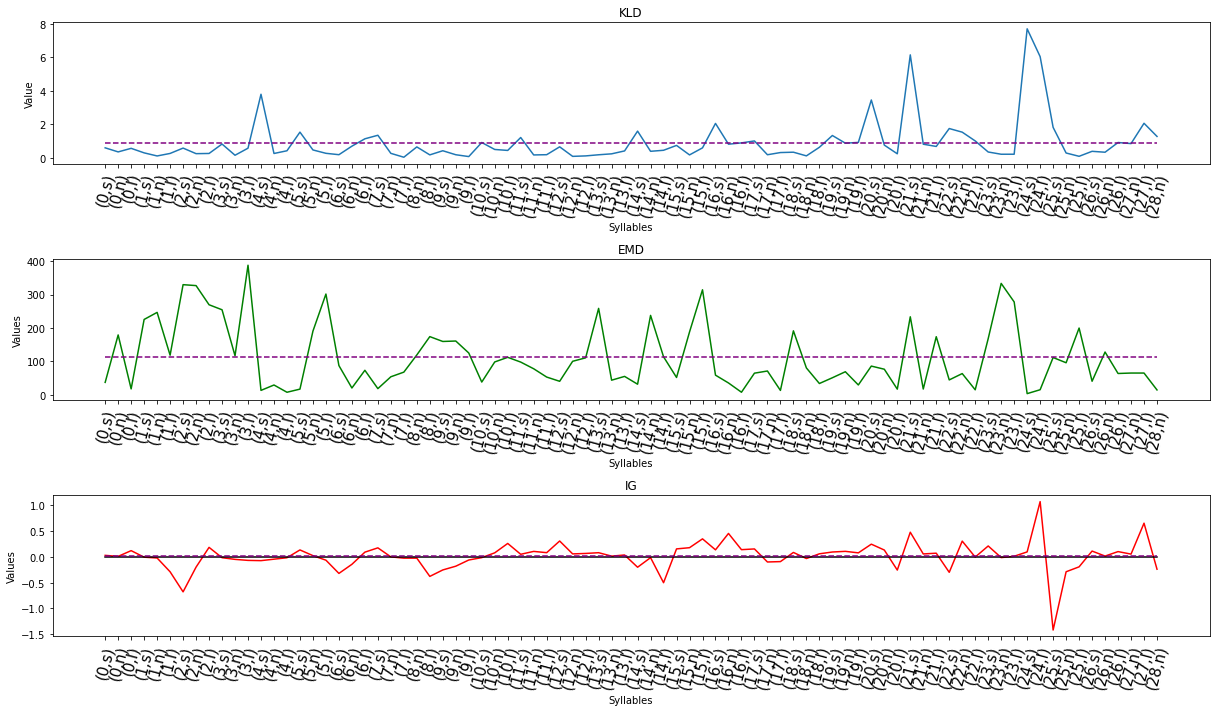

 
(Order 2) comparison between the two halves of Pre-Surgery


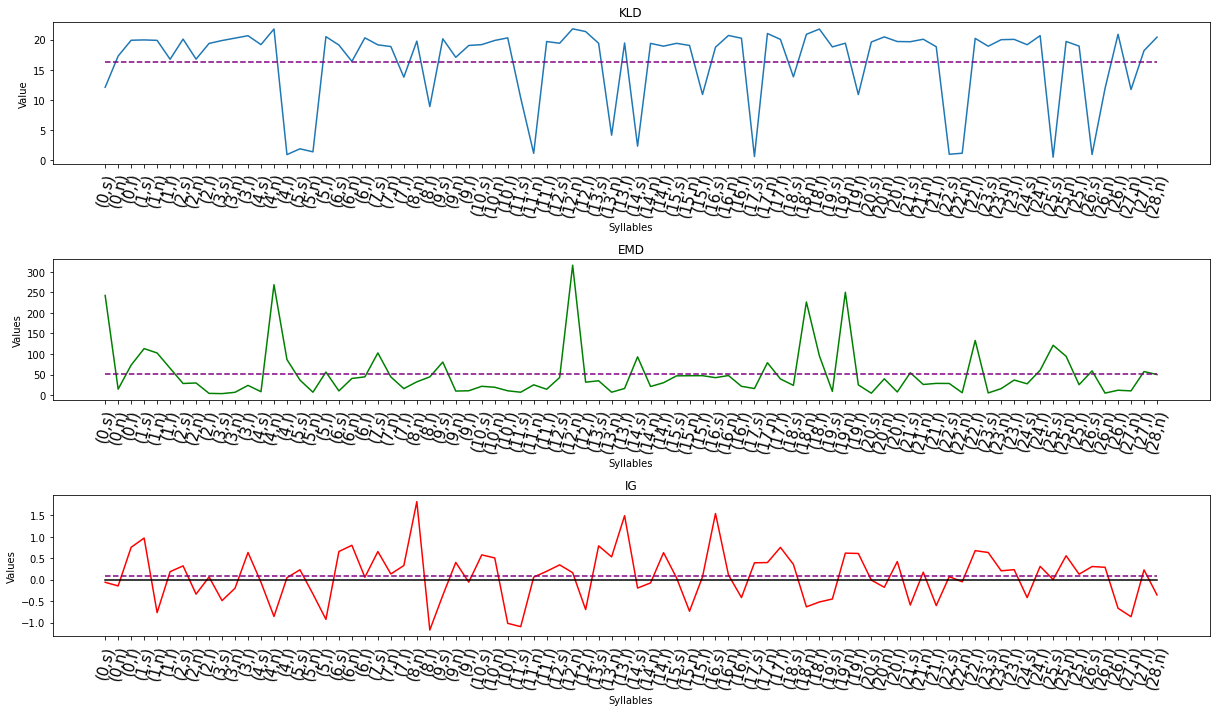

 
(Order 3) comparison between the two halves of Pre-Surgery


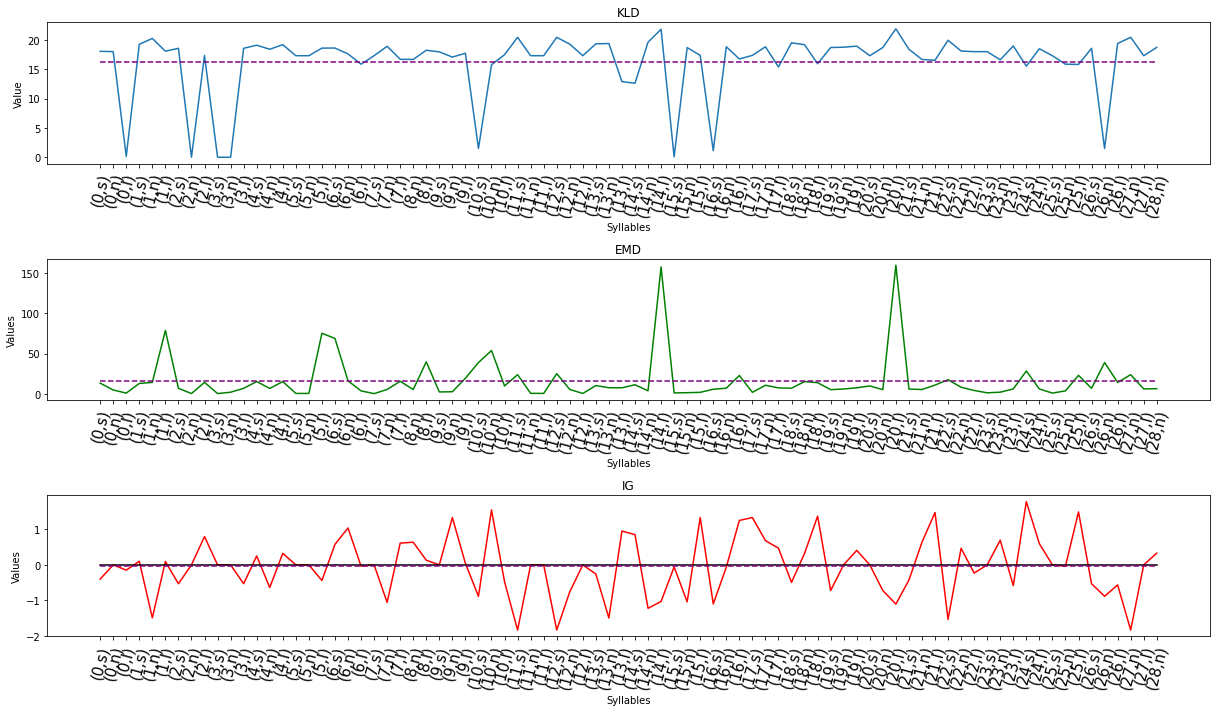

In [93]:
#Plots all 3 metrics for all three orders for this comparison
# NOTE: ignore orders 2 and 3 as they are not comparing 
#  anything meaningful (except maybe by accident)
#  They are kept as a demonstration of the setup.


print('(Order 1) comparison between the two halves of Pre-Surgery')
fig, axes = plt.subplots(3, 1, figsize=(17, 10))
axes[0].plot(plotsyl,plotKLD1)
axes[0].plot([0,len(plotsyl)-1],[fsKLD1avg,fsKLD1avg],'purple',linestyle='--')
axes[0].tick_params(axis='x', labelrotation=75,labelsize=15)
#axes[0].set_ylim([0,1])
axes[0].set_title("KLD".format(cur_syl))
axes[0].set_xlabel("Syllables")
axes[0].set_ylabel("Value")
axes[1].plot(plotsyl,plotEMD1,'green')
axes[1].plot([0,len(plotsyl)-1],[fsEMD1avg,fsEMD1avg],'purple',linestyle='--')
axes[1].tick_params(axis='x', labelrotation=75,labelsize=15)
#axes[1].set_ylim([0,1])
axes[1].set_title("EMD".format(cur_syl))
axes[1].set_xlabel("Syllables")
axes[1].set_ylabel("Values")
axes[2].plot(plotsyl,plotIG1,'red')
axes[2].plot([0,len(plotsyl)-1],[0,0],'black')
axes[2].plot([0,len(plotsyl)-1],[fsIG1avg,fsIG1avg],'purple',linestyle='--')
axes[2].tick_params(axis='x', labelrotation=75,labelsize=15)
#axes[2].set_ylim([0,1])
axes[2].set_title("IG".format(cur_syl))
axes[2].set_xlabel("Syllables")
axes[2].set_ylabel("Values")
plt.tight_layout()
plt.show()
print(' ')
print('(Order 2) comparison between the two halves of Pre-Surgery')
fig, axes = plt.subplots(3, 1, figsize=(17, 10))
axes[0].plot(plotsyl,plotKLD2)
axes[0].plot([0,len(plotsyl)-1],[fsKLD2avg,fsKLD2avg],'purple',linestyle='--')
axes[0].tick_params(axis='x', labelrotation=75,labelsize=15)
#axes[0].set_ylim([0,1])
axes[0].set_title("KLD".format(cur_syl))
axes[0].set_xlabel("Syllables")
axes[0].set_ylabel("Value")
axes[1].plot(plotsyl,plotEMD2,'green')
axes[1].plot([0,len(plotsyl)-1],[fsEMD2avg,fsEMD2avg],'purple',linestyle='--')
axes[1].tick_params(axis='x', labelrotation=75,labelsize=15)
#axes[1].set_ylim([0,1])
axes[1].set_title("EMD".format(cur_syl))
axes[1].set_xlabel("Syllables")
axes[1].set_ylabel("Values")
axes[2].plot(plotsyl,plotIG2,'red')
axes[2].plot([0,len(plotsyl)-1],[0,0],'black')
axes[2].plot([0,len(plotsyl)-1],[fsIG2avg,fsIG2avg],'purple',linestyle='--')
axes[2].tick_params(axis='x', labelrotation=75,labelsize=15)
#axes[2].set_ylim([0,1])
axes[2].set_title("IG".format(cur_syl))
axes[2].set_xlabel("Syllables")
axes[2].set_ylabel("Values")
plt.tight_layout()
plt.show()
print(' ')
print('(Order 3) comparison between the two halves of Pre-Surgery')
fig, axes = plt.subplots(3, 1, figsize=(17, 10))
axes[0].plot(plotsyl,plotKLD3)
axes[0].plot([0,len(plotsyl)-1],[fsKLD3avg,fsKLD3avg],'purple',linestyle='--')
axes[0].tick_params(axis='x', labelrotation=75,labelsize=15)
#axes[0].set_ylim([0,1])
axes[0].set_title("KLD".format(cur_syl))
axes[0].set_xlabel("Syllables")
axes[0].set_ylabel("Value")
axes[1].plot(plotsyl,plotEMD3,'green')
axes[1].plot([0,len(plotsyl)-1],[fsEMD3avg,fsEMD3avg],'purple',linestyle='--')
axes[1].tick_params(axis='x', labelrotation=75,labelsize=15)
#axes[1].set_ylim([0,1])
axes[1].set_title("EMD".format(cur_syl))
axes[1].set_xlabel("Syllables")
axes[1].set_ylabel("Values")
axes[2].plot(plotsyl,plotIG3,'red')
axes[2].plot([0,len(plotsyl)-1],[0,0],'black')
axes[2].plot([0,len(plotsyl)-1],[fsIG3avg,fsIG3avg],'purple',linestyle='--')
axes[2].tick_params(axis='x', labelrotation=75,labelsize=15)
#axes[2].set_ylim([0,1])
axes[2].set_title("IG".format(cur_syl))
axes[2].set_xlabel("Syllables")
axes[2].set_ylabel("Values")
plt.tight_layout()
plt.show()

In [94]:
#Please see the version of this cell just below where the baseAlphabet is defined 
plotKLD1 = []
plotIG1 = []
plotEMD1 = []

plotKLD2 = []
plotIG2 = []
plotEMD2 = []

plotKLD3 = []
plotIG3 = []
plotEMD3 = []

plotsyl = []
for idx in range(len(baseAlphabet)):
    pre_syl = np.nan
    post_syl = np.nan
    cur_syl = baseAlphabet[idx]
    #print(cur_syl)
    #print((pre_surgery1_pst.tree[1]['label'][idx]))
    #print('From ',THEalphabet[idx])
    #print(len(pre_surgery1_pst.tree[order]['p'][idx]), len(post_surgery_pst.tree[order]['p'][idx]))
    for i in range(len(pre_surgery1_pst.tree[order]['label'])):
        if cur_syl in pre_surgery1_pst.tree[order]['label'][i]:
            #pre_syl = pre_surgery1_pst.tree[order]['label'].index(cur_syl)
            pre_syl = i
            pre_probs1 = pre_surgery1_pst.tree[order]['p'][pre_syl]
            pre_probs2 = pre_surgery1_pst.tree[order+1]['p'][pre_syl]
            pre_probs3 = pre_surgery1_pst.tree[order+2]['p'][pre_syl]
            continue
    #post_probs = post_surgery_pst.tree[order]['p'][idx]
    for i in range(len(post_surgery_pst.tree[order]['label'])):
        if cur_syl in post_surgery_pst.tree[order]['label'][i]: 
            #post_syl = pre_surgery2_pst.tree[order]['label'].index(cur_syl)
            post_syl = i
            post_probs1 = post_surgery_pst.tree[order]['p'][post_syl]
            post_probs2 = post_surgery_pst.tree[order+1]['p'][post_syl]
            post_probs3 = post_surgery_pst.tree[order+2]['p'][post_syl]
    if type(pre_syl) == int:
        if type(post_syl)==int:
            #norm_pre_probs = (pre_probs + (1e-12)) / np.sum(pre_probs)
            #norm_post_probs = (post_probs + (1e-12)) / np.sum(post_probs)
            
            plotsyl.append(cur_syl)
            norm_pre_probs = (pre_probs1 + (1e-12)) / np.sum(pre_probs1)
            norm_post_probs = (post_probs1 + (1e-12)) / np.sum(post_probs1)
            
            #Computes the metrics comparing the order 1 between the
            #  two datasets and prepares a list of results for
            #  plotting in the next cell
            kld,emd,ig = calculate_metrics(norm_pre_probs, norm_post_probs)
            plotKLD1.append(kld)
            plotEMD1.append(emd)
            plotIG1.append(ig) 

            #DOES NOT WORK AS INTENDED
            ###########################################################
            norm_pre_probs = (pre_probs2 + (1e-12)) / np.sum(pre_probs2)
            norm_post_probs = (post_probs2 + (1e-12)) / np.sum(post_probs2)
            
            kld,emd,ig = calculate_metrics(norm_pre_probs, norm_post_probs)
            plotKLD2.append(kld)
            plotEMD2.append(emd)
            plotIG2.append(ig) 

            norm_pre_probs = (pre_probs3 + (1e-12)) / np.sum(pre_probs3)
            norm_post_probs = (post_probs3 + (1e-12)) / np.sum(post_probs3)
            
            kld,emd,ig = calculate_metrics(norm_pre_probs, norm_post_probs)
            plotKLD3.append(kld)
            plotEMD3.append(emd)
            plotIG3.append(ig) 
            ###########################################################
            #pprint.pprint(metrics)

In [95]:
#This cell establishes an average to accompany each plot
#  Each average is preserved and presented in tabular
#   form in the very last cell of this notebook

#converts each of the lists into numpy arrays for further processing
plotKLD1=np.array(plotKLD1)
plotEMD1=np.array(plotEMD1)
plotIG1 =np.array(plotIG1)

plotKLD2=np.array(plotKLD2)
plotEMD2=np.array(plotEMD2)
plotIG2 =np.array(plotIG2)

plotKLD3=np.array(plotKLD3)
plotEMD3=np.array(plotEMD3)
plotIG3 =np.array(plotIG3)

#Establishes means of each metric for each order
fpostKLD1avg = np.average(plotKLD1)
fpostEMD1avg = np.average(plotEMD1)
fpostIG1avg = np.average(plotIG1)

fpostKLD2avg = np.average(plotKLD2)
fpostEMD2avg = np.average(plotEMD2)
fpostIG2avg = np.average(plotIG2)

fpostKLD3avg = np.average(plotKLD3)
fpostEMD3avg = np.average(plotEMD3)
fpostIG3avg = np.average(plotIG3)

In [1]:
#Plots all 3 metrics for all three orders for this comparison
# NOTE: ignore orders 2 and 3 as they are not comparing 
#  anything meaningful (except maybe by accident)
#  They are kept as a demonstration of the setup.

print('(Order 1) comparison between 1st half of pre-surgery and Post-Surgery')
fig, axes = plt.subplots(3, 1, figsize=(17, 10))
axes[0].plot(plotsyl,plotKLD1)
axes[0].plot([0,len(plotsyl)-1],[fpostKLD1avg,fpostKLD1avg],'purple',linestyle='--')
axes[0].tick_params(axis='x', labelrotation=75,labelsize=15)
#axes[0].set_ylim([0,1])
axes[0].set_title("KLD".format(cur_syl))
axes[0].set_xlabel("Syllables")
axes[0].set_ylabel("Value")
axes[1].plot(plotsyl,plotEMD1,'green')
axes[1].plot([0,len(plotsyl)-1],[fpostEMD1avg,fpostEMD1avg],'purple',linestyle='--')
axes[1].tick_params(axis='x', labelrotation=75,labelsize=15)
#axes[1].set_ylim([0,1])
axes[1].set_title("EMD".format(cur_syl))
axes[1].set_xlabel("Syllables")
axes[1].set_ylabel("Values")
axes[2].plot(plotsyl,plotIG1,'red')
axes[2].plot([0,len(plotsyl)-1],[0,0],'black')
axes[2].plot([0,len(plotsyl)-1],[fpostIG1avg,fpostIG1avg],'purple',linestyle='--')
axes[2].tick_params(axis='x', labelrotation=75,labelsize=15)
#axes[2].set_ylim([0,1])
axes[2].set_title("IG".format(cur_syl))
axes[2].set_xlabel("Syllables")
axes[2].set_ylabel("Values")
plt.tight_layout()
plt.show()
print(' ')
print('(Order 2) comparison between 1st half of pre-surgery and Post-Surgery')
fig, axes = plt.subplots(3, 1, figsize=(17, 10))
axes[0].plot(plotsyl,plotKLD2)
axes[0].plot([0,len(plotsyl)-1],[fpostKLD2avg,fpostKLD2avg],'purple',linestyle='--')
axes[0].tick_params(axis='x', labelrotation=75,labelsize=15)
#axes[0].set_ylim([0,1])
axes[0].set_title("KLD".format(cur_syl))
axes[0].set_xlabel("Syllables")
axes[0].set_ylabel("Value")
axes[1].plot(plotsyl,plotEMD2,'green')
axes[1].plot([0,len(plotsyl)-1],[fpostEMD2avg,fpostEMD2avg],'purple',linestyle='--')
axes[1].tick_params(axis='x', labelrotation=75,labelsize=15)
#axes[1].set_ylim([0,1])
axes[1].set_title("EMD".format(cur_syl))
axes[1].set_xlabel("Syllables")
axes[1].set_ylabel("Values")
axes[2].plot(plotsyl,plotIG2,'red')
axes[2].plot([0,len(plotsyl)-1],[0,0],'black')
axes[2].plot([0,len(plotsyl)-1],[fpostIG2avg,fpostIG2avg],'purple',linestyle='--')
axes[2].tick_params(axis='x', labelrotation=75,labelsize=15)
#axes[2].set_ylim([0,1])
axes[2].set_title("IG".format(cur_syl))
axes[2].set_xlabel("Syllables")
axes[2].set_ylabel("Values")
plt.tight_layout()
plt.show()
print(' ')
print('(Order 3) comparison between 1st half of pre-surgery and Post-Surgery')
fig, axes = plt.subplots(3, 1, figsize=(17, 10))
axes[0].plot(plotsyl,plotKLD3)
axes[0].plot([0,len(plotsyl)-1],[fpostKLD3avg,fpostKLD3avg],'purple',linestyle='--')
axes[0].tick_params(axis='x', labelrotation=75,labelsize=15)
#axes[0].set_ylim([0,1])
axes[0].set_title("KLD".format(cur_syl))
axes[0].set_xlabel("Syllables")
axes[0].set_ylabel("Value")
axes[1].plot(plotsyl,plotEMD3,'green')
axes[1].plot([0,len(plotsyl)-1],[fpostEMD3avg,fpostEMD3avg],'purple',linestyle='--')
axes[1].tick_params(axis='x', labelrotation=75,labelsize=15)
#axes[1].set_ylim([0,1])
axes[1].set_title("EMD".format(cur_syl))
axes[1].set_xlabel("Syllables")
axes[1].set_ylabel("Values")
axes[2].plot(plotsyl,plotIG3,'red')
axes[2].plot([0,len(plotsyl)-1],[0,0],'black')
axes[2].plot([0,len(plotsyl)-1],[fpostIG3avg,fpostIG3avg],'purple',linestyle='--')
axes[2].tick_params(axis='x', labelrotation=75,labelsize=15)
#axes[2].set_ylim([0,1])
axes[2].set_title("IG".format(cur_syl))
axes[2].set_xlabel("Syllables")
axes[2].set_ylabel("Values")
plt.tight_layout()
plt.show()

(Order 1) comparison between 1st half of pre-surgery and Post-Surgery


NameError: name 'plt' is not defined

In [97]:
#Please see the version of this cell just below where the baseAlphabet is defined 
plotKLD1 = []
plotIG1 = []
plotEMD1 = []

plotKLD2 = []
plotIG2 = []
plotEMD2 = []

plotKLD3 = []
plotIG3 = []
plotEMD3 = []

plotsyl = []
for idx in range(len(baseAlphabet)):
    pre_syl = np.nan
    post_syl = np.nan
    cur_syl = baseAlphabet[idx]
    #print(cur_syl)
    #print((pre_surgery1_pst.tree[1]['label'][idx]))
    #print('From ',THEalphabet[idx])
    #print(len(pre_surgery1_pst.tree[order]['p'][idx]), len(post_surgery_pst.tree[order]['p'][idx]))
    for i in range(len(pre_surgery2_pst.tree[order]['label'])):
        if cur_syl in pre_surgery2_pst.tree[order]['label'][i]:
            #pre_syl = pre_surgery1_pst.tree[order]['label'].index(cur_syl)
            pre_syl = i
            pre_probs1 = pre_surgery2_pst.tree[order]['p'][pre_syl]
            pre_probs2 = pre_surgery2_pst.tree[order+1]['p'][pre_syl]
            pre_probs3 = pre_surgery2_pst.tree[order+2]['p'][pre_syl]
            continue
    #post_probs = post_surgery_pst.tree[order]['p'][idx]
    for i in range(len(post_surgery_pst.tree[order]['label'])):
        if cur_syl in post_surgery_pst.tree[order]['label'][i]: 
            #post_syl = pre_surgery2_pst.tree[order]['label'].index(cur_syl)
            post_syl = i
            post_probs1 = post_surgery_pst.tree[order]['p'][post_syl]
            post_probs2 = post_surgery_pst.tree[order+1]['p'][post_syl]
            post_probs3 = post_surgery_pst.tree[order+2]['p'][post_syl]
    if type(pre_syl) == int:
        if type(post_syl)==int:
            
            plotsyl.append(cur_syl)

            norm_pre_probs = (pre_probs1 + (1e-12)) / np.sum(pre_probs1)
            norm_post_probs = (post_probs1 + (1e-12)) / np.sum(post_probs1)
            
            #Computes the metrics comparing the order 1 between the
            #  two datasets and prepares a list of results for
            #  plotting in the next cell
            kld,emd,ig = calculate_metrics(norm_pre_probs, norm_post_probs)
            plotKLD1.append(kld)
            plotEMD1.append(emd)
            plotIG1.append(ig) 

            #DOES NOT WORK AS INTENDED
            ###########################################################
            norm_pre_probs = (pre_probs2 + (1e-12)) / np.sum(pre_probs2)
            norm_post_probs = (post_probs2 + (1e-12)) / np.sum(post_probs2)
            
            kld,emd,ig = calculate_metrics(norm_pre_probs, norm_post_probs)
            plotKLD2.append(kld)
            plotEMD2.append(emd)
            plotIG2.append(ig) 

            norm_pre_probs = (pre_probs3 + (1e-12)) / np.sum(pre_probs3)
            norm_post_probs = (post_probs3 + (1e-12)) / np.sum(post_probs3)
            
            kld,emd,ig = calculate_metrics(norm_pre_probs, norm_post_probs)
            plotKLD3.append(kld)
            plotEMD3.append(emd)
            plotIG3.append(ig) 
            ###########################################################
            
            #pprint.pprint(metrics)

In [98]:
#This cell establishes an average to accompany each plot
#  Each average is preserved and presented in tabular
#   form in the very last cell of this notebook

#converts each of the lists into numpy arrays for further processing
plotKLD1=np.array(plotKLD1)
plotEMD1=np.array(plotEMD1)
plotIG1 =np.array(plotIG1)

plotKLD2=np.array(plotKLD2)
plotEMD2=np.array(plotEMD2)
plotIG2 =np.array(plotIG2)

plotKLD3=np.array(plotKLD3)
plotEMD3=np.array(plotEMD3)
plotIG3 =np.array(plotIG3)

#Establishes means of each metric for each order
spostKLD1avg = np.average(plotKLD1)
spostEMD1avg = np.average(plotEMD1)
spostIG1avg = np.average(plotIG1)

spostKLD2avg = np.average(plotKLD2)
spostEMD2avg = np.average(plotEMD2)
spostIG2avg = np.average(plotIG2)

spostKLD3avg = np.average(plotKLD3)
spostEMD3avg = np.average(plotEMD3)
spostIG3avg = np.average(plotIG3)

(Order 1) comparison between 2nd half of pre-surgery and Post-Surgery


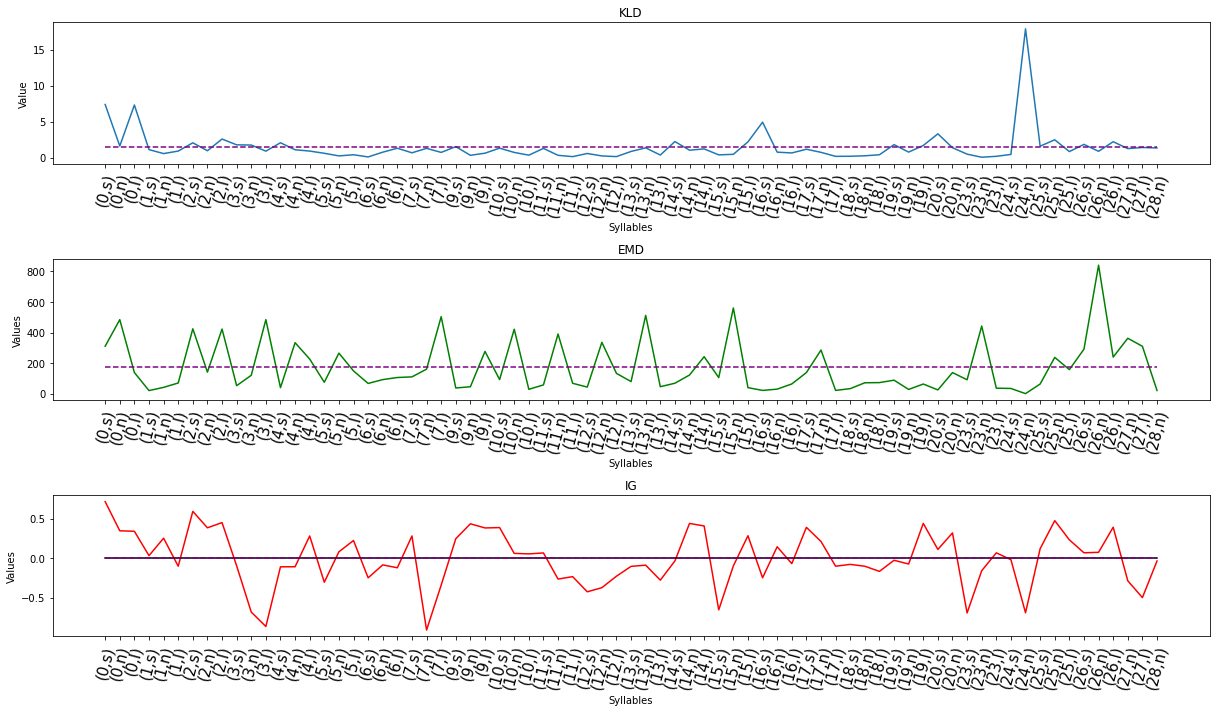

 
(Order 2) comparison between 2nd half of pre-surgery and Post-Surgery


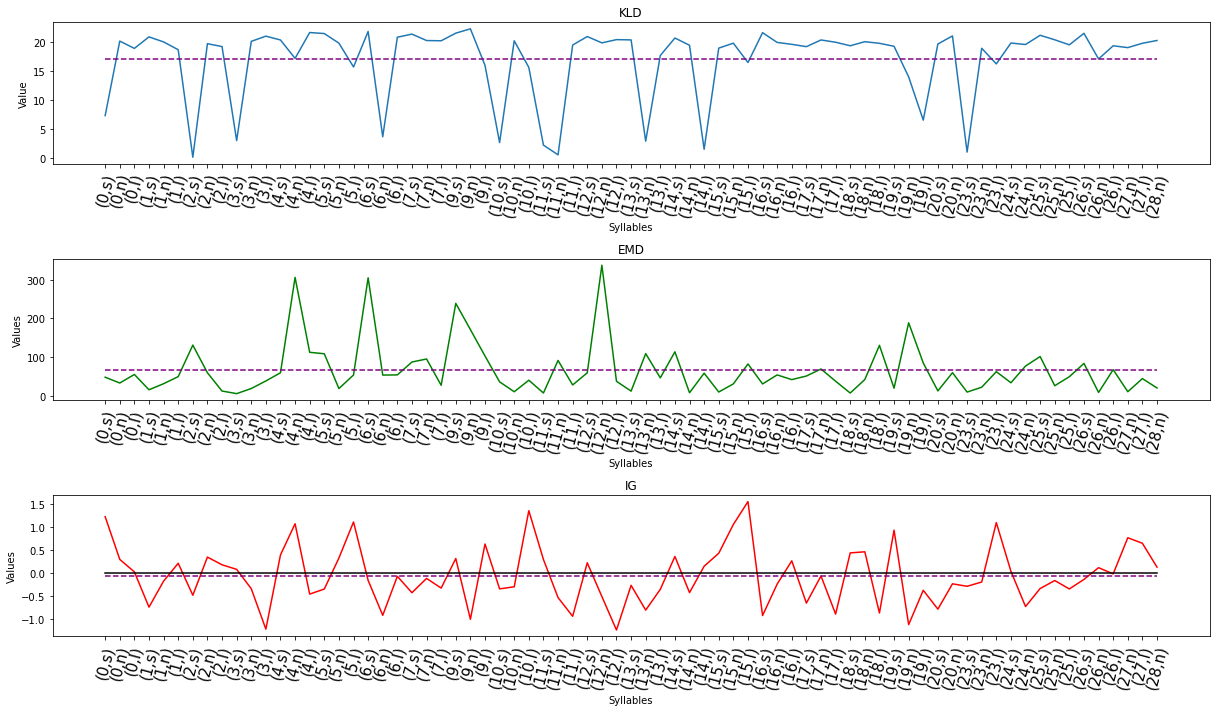

 
(Order 3) comparison between 2nd half of pre-surgery and Post-Surgery


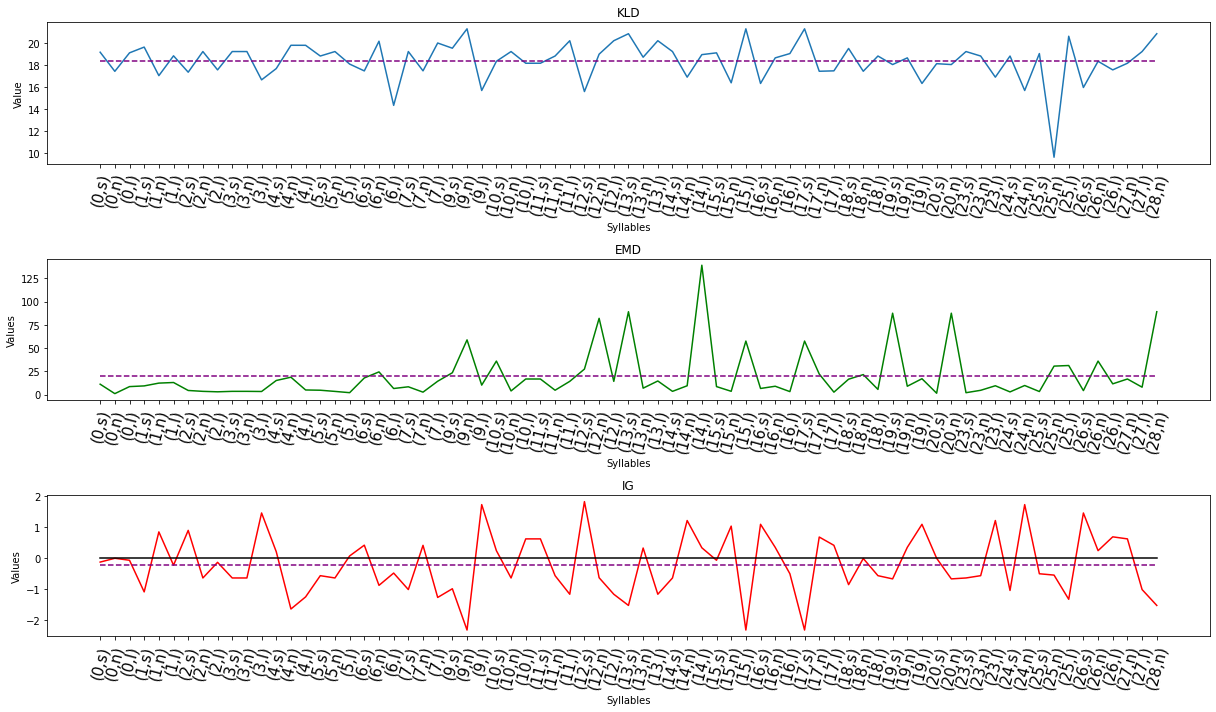

In [99]:
#Plots all 3 metrics for all three orders for this comparison
# NOTE: ignore orders 2 and 3 as they are not comparing 
#  anything meaningful (except maybe by accident)
#  They are kept as a demonstration of the setup.

print('(Order 1) comparison between 2nd half of pre-surgery and Post-Surgery')
fig, axes = plt.subplots(3, 1, figsize=(17, 10))
axes[0].plot(plotsyl,plotKLD1)
axes[0].plot([0,len(plotsyl)-1],[spostKLD1avg,spostKLD1avg],'purple',linestyle='--')
axes[0].tick_params(axis='x', labelrotation=75,labelsize=15)
#axes[0].set_ylim([0,1])
axes[0].set_title("KLD".format(cur_syl))
axes[0].set_xlabel("Syllables")
axes[0].set_ylabel("Value")
axes[1].plot(plotsyl,plotEMD1,'green')
axes[1].plot([0,len(plotsyl)-1],[spostEMD1avg,spostEMD1avg],'purple',linestyle='--')
axes[1].tick_params(axis='x', labelrotation=75,labelsize=15)
#axes[1].set_ylim([0,1])
axes[1].set_title("EMD".format(cur_syl))
axes[1].set_xlabel("Syllables")
axes[1].set_ylabel("Values")
axes[2].plot(plotsyl,plotIG1,'red')
axes[2].plot([0,len(plotsyl)-1],[0,0],'black')
axes[2].plot([0,len(plotsyl)-1],[spostIG1avg,spostIG1avg],'purple',linestyle='--')
axes[2].tick_params(axis='x', labelrotation=75,labelsize=15)
#axes[2].set_ylim([0,1])
axes[2].set_title("IG".format(cur_syl))
axes[2].set_xlabel("Syllables")
axes[2].set_ylabel("Values")
plt.tight_layout()
plt.show()
print(' ')
print('(Order 2) comparison between 2nd half of pre-surgery and Post-Surgery')
fig, axes = plt.subplots(3, 1, figsize=(17, 10))
axes[0].plot(plotsyl,plotKLD2)
axes[0].plot([0,len(plotsyl)-1],[spostKLD2avg,spostKLD2avg],'purple',linestyle='--')
axes[0].tick_params(axis='x', labelrotation=75,labelsize=15)
#axes[0].set_ylim([0,1])
axes[0].set_title("KLD".format(cur_syl))
axes[0].set_xlabel("Syllables")
axes[0].set_ylabel("Value")
axes[1].plot(plotsyl,plotEMD2,'green')
axes[1].plot([0,len(plotsyl)-1],[spostEMD2avg,spostEMD2avg],'purple',linestyle='--')
axes[1].tick_params(axis='x', labelrotation=75,labelsize=15)
#axes[1].set_ylim([0,1])
axes[1].set_title("EMD".format(cur_syl))
axes[1].set_xlabel("Syllables")
axes[1].set_ylabel("Values")
axes[2].plot(plotsyl,plotIG2,'red')
axes[2].plot([0,len(plotsyl)-1],[0,0],'black')
axes[2].plot([0,len(plotsyl)-1],[spostIG2avg,spostIG2avg],'purple',linestyle='--')
axes[2].tick_params(axis='x', labelrotation=75,labelsize=15)
#axes[2].set_ylim([0,1])
axes[2].set_title("IG".format(cur_syl))
axes[2].set_xlabel("Syllables")
axes[2].set_ylabel("Values")
plt.tight_layout()
plt.show()
print(' ')
print('(Order 3) comparison between 2nd half of pre-surgery and Post-Surgery')
fig, axes = plt.subplots(3, 1, figsize=(17, 10))
axes[0].plot(plotsyl,plotKLD3)
axes[0].plot([0,len(plotsyl)-1],[spostKLD3avg,spostKLD3avg],'purple',linestyle='--')
axes[0].tick_params(axis='x', labelrotation=75,labelsize=15)
#axes[0].set_ylim([0,1])
axes[0].set_title("KLD".format(cur_syl))
axes[0].set_xlabel("Syllables")
axes[0].set_ylabel("Value")
axes[1].plot(plotsyl,plotEMD3,'green')
axes[1].plot([0,len(plotsyl)-1],[spostEMD3avg,spostEMD3avg],'purple',linestyle='--')
axes[1].tick_params(axis='x', labelrotation=75,labelsize=15)
#axes[1].set_ylim([0,1])
axes[1].set_title("EMD".format(cur_syl))
axes[1].set_xlabel("Syllables")
axes[1].set_ylabel("Values")
axes[2].plot(plotsyl,plotIG3,'red')
axes[2].plot([0,len(plotsyl)-1],[0,0],'black')
axes[2].plot([0,len(plotsyl)-1],[spostIG3avg,spostIG3avg],'purple',linestyle='--')
axes[2].tick_params(axis='x', labelrotation=75,labelsize=15)
#axes[2].set_ylim([0,1])
axes[2].set_title("IG".format(cur_syl))
axes[2].set_xlabel("Syllables")
axes[2].set_ylabel("Values")
plt.tight_layout()
plt.show()

In [124]:
#A table of averages for each metric for each order for each comparison
#  NOTE: 2nd and 3rd order results are meaningless as they are not
#   comparing the same phrase combinations. They are kept here
#   as a demonstration

print(f''' 
Order | 1st-2nd | 1st-Post | 2nd-Post |
_______________________________________
      |{np.round(fsKLD1avg,3)}    |{np.round(fpostKLD1avg,3)}     |{np.round(spostKLD1avg,3)}       | KLD
   1  |{np.round(fsEMD1avg,3)}  |{np.round(fpostEMD1avg,3)}   |{np.round(spostEMD1avg,3)}    | EMD
      |{np.round(fsIG1avg,3)}    |{np.round(fpostIG1avg,3)}      |{np.round(spostIG1avg,3)}     | IG
_______________________________________
      |{np.round(fsKLD2avg,3)}   |{np.round(fpostKLD2avg,3)}    |{np.round(spostKLD2avg,3)}     | KLD
   2  |{np.round(fsEMD2avg,3)}   |{np.round(fpostEMD2avg,3)}    |{np.round(spostEMD2avg,3)}       | EMD
      |{np.round(fsIG2avg,3)}    |{np.round(fpostIG2avg,3)}     |{np.round(spostIG2avg,3)}     | IG
_______________________________________
      |{np.round(fsKLD3avg,3)}   |{np.round(fpostKLD3avg,3)}    |{np.round(spostKLD3avg,3)}     | KLD
   3  |{np.round(fsEMD3avg,3)}   |{np.round(fpostEMD3avg,3)}    |{np.round(spostEMD3avg,3)}     | EMD
      |{np.round(fsIG3avg,3)}   |{np.round(fpostIG3avg,3)}    |{np.round(spostIG3avg,3)}     | IG
_______________________________________
''')

 
Order | 1st-2nd | 1st-Post | 2nd-Post |
_______________________________________
      |0.906    |1.775     |1.46       | KLD
   1  |111.727  |209.883   |174.676    | EMD
      |0.013    |-0.0      |-0.005     | IG
_______________________________________
      |16.291   |17.241    |17.059     | KLD
   2  |51.736   |59.873    |66.4       | EMD
      |0.086    |0.013     |-0.058     | IG
_______________________________________
      |16.282   |13.845    |18.384     | KLD
   3  |16.025   |20.937    |19.918     | EMD
      |-0.037   |-0.302    |-0.203     | IG
_______________________________________

